## Required Libraries

In [ ]:
!pip install torch

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
import os
import torch
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameter Tuning with 100k dataset

### Loading Data and Creating Index Mappings

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-latest-small/ratings.csv', encoding='utf-8') as file:
#with open('.//ml-latest-small/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp


### Splitting Data into Training and Test Sets

In [ ]:
# Define the number of last ratings to use as test data
m = 5  # Use last 5 ratings of each user for testing

# Split the data into training and test sets
train_user_ids, train_movie_ids, train_ratings = [], [], []
test_user_ids, test_movie_ids, test_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    if len(ratings) > m:
        # Training data
        for movie_id, rating, _ in ratings[:-m]:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)
        # Test data
        for movie_id, rating, _ in ratings[-m:]:
            test_user_ids.append(user_idx)
            test_movie_ids.append(movie_to_index[movie_id])
            test_ratings.append(rating)
    else:
        # Use all for training if not enough ratings
        for movie_id, rating, _ in ratings:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)

### Handling Cold Start Items

In [ ]:
# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)
test_user_ids = np.array(test_user_ids)
test_movie_ids = np.array(test_movie_ids)
test_ratings = np.array(test_ratings)

# Check for cold start items in the test set
train_movie_set = set(train_movie_ids)
cold_start_indices = [i for i, movie_id in enumerate(test_movie_ids) if movie_id not in train_movie_set]

# Add cold start items to the training set
if cold_start_indices:
    train_user_ids = np.concatenate((train_user_ids, test_user_ids[cold_start_indices]))
    train_movie_ids = np.concatenate((train_movie_ids, test_movie_ids[cold_start_indices]))
    train_ratings = np.concatenate((train_ratings, test_ratings[cold_start_indices]))

### Re-indexing the Data

In [ ]:
# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Remap test user and movie indices
indexed_test_user_ids = np.array([train_user_to_index.get(uid, -1) for uid in test_user_ids])
indexed_test_movie_ids = np.array([train_movie_to_index.get(mid, -1) for mid in test_movie_ids])

# Filter valid test indices to ensure they are known in the training set
valid_test_indices = (indexed_test_user_ids != -1) & (indexed_test_movie_ids != -1)

test_user_ids = indexed_test_user_ids[valid_test_indices]
test_movie_ids = indexed_test_movie_ids[valid_test_indices]
test_ratings = test_ratings[valid_test_indices]

# Output the shapes of the training and test sets
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)
print("Test data:", test_user_ids.shape, test_movie_ids.shape, test_ratings.shape)

# Report the number of cold start items
total_test_items = len(test_movie_ids)
removed_count = len(cold_start_indices)
print(f"Total test items: {total_test_items}")
print(f"Cold start items added to training set: {removed_count}")
print(f"Percentage of cold start items: {removed_count / total_test_items * 100:.2f}%")

Training data: (97896,) (97896,) (97896,)
Test data: (3050,) (3050,) (3050,)
Total test items: 3050
Cold start items added to training set: 110
Percentage of cold start items: 3.61%


## Build a model that finds Maximum Likelihood Estimate for user, item biases and factors with alternating least squares

In [ ]:
def initialize_factors(user_ids, movie_ids, num_factors):
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)
    user_bias = np.zeros(len(unique_users))
    item_bias = np.zeros(len(unique_movies))
    user_factors = np.random.normal(0, 0.1, (len(unique_users), num_factors))
    item_factors = np.random.normal(0, 0.1, (len(unique_movies), num_factors))
    return user_bias, item_bias, user_factors, item_factors

def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    errors = ratings - predictions
    loss = 0.5 * np.sum(errors**2)
    regularization_bias = 0.5 * gamma_bias * (np.sum(user_bias**2) + np.sum(item_bias**2))
    regularization_factors = 0.5 * gamma_latent * (np.sum(user_factors**2) + np.sum(item_factors**2))
    return lambda_reg * loss + regularization_bias + regularization_factors

def predict_rating(user_ids, movie_ids, user_bias, item_bias, user_factors, item_factors):
    dot_products = np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    predictions = user_bias[user_ids] + item_bias[movie_ids] + dot_products
    return predictions

def calculate_rmse(predictions, actual_ratings):
    mse = np.mean((predictions - actual_ratings) ** 2)
    return np.sqrt(mse)

In [ ]:
def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    # Calculate user biases using the ALS algorithm
    for user_id in np.unique(user_ids):
        indices = np.where(user_ids == user_id)[0]
        item_indices = movie_ids[indices]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[item_indices]
        user_factor = user_factors[user_id]
        item_factors_subset = item_factors[item_indices]

        num_items = len(indices)
        dot_product = np.dot(item_factors_subset, user_factor)

        # Update equation implementation
        numerator = lambda_reg * np.sum(ratings_subset - item_bias_subset - dot_product)
        denominator = lambda_reg * num_items + gamma_bias
        user_bias[user_id] = numerator / denominator

    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    # Calculate item biases using the ALS algorithm
    for movie_id in np.unique(movie_ids):
        indices = np.where(movie_ids == movie_id)[0]
        user_indices = user_ids[indices]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_indices]
        item_factor = item_factors[movie_id]
        user_factors_subset = user_factors[user_indices]

        num_users = len(indices)
        dot_product = np.dot(user_factors_subset, item_factor)

        # Update equation implementation
        numerator = lambda_reg * np.sum(ratings_subset - user_bias_subset - dot_product)
        denominator = lambda_reg * num_users + gamma_bias
        item_bias[movie_id] = numerator / denominator

    return item_bias

In [ ]:
def update_user_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    for user_id in np.unique(user_ids):
        indices = np.where(user_ids == user_id)[0]
        V_i = item_factors[movie_ids[indices]]
        A = lambda_reg * np.dot(V_i.T, V_i) + gamma_latent * np.eye(V_i.shape[1])
        residuals = ratings[indices] - user_bias[user_id] - item_bias[movie_ids[indices]]
        b = lambda_reg * np.sum(residuals[:, np.newaxis] * V_i, axis=0)
        user_factors[user_id] = np.linalg.solve(A, b)
    return user_factors

def update_item_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    for movie_id in np.unique(movie_ids):
        indices = np.where(movie_ids == movie_id)[0]
        U_j = user_factors[user_ids[indices]]
        A = lambda_reg * np.dot(U_j.T, U_j) + gamma_latent * np.eye(U_j.shape[1])
        residuals = ratings[indices] - user_bias[user_ids[indices]] - item_bias[movie_id]
        b = lambda_reg * np.sum(residuals[:, np.newaxis] * U_j, axis=0)
        item_factors[movie_id] = np.linalg.solve(A, b)
    return item_factors

In [ ]:
def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings, iterations, num_factors, lambda_reg, gamma_latent, gamma_bias):
    user_bias, item_bias, user_factors, item_factors = initialize_factors(train_user_ids, train_movie_ids, num_factors)
    train_rmses = []
    test_rmses = []
    train_losses = []
    test_losses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)

        user_factors = update_user_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        item_factors = update_item_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)

        # Compute predictions and RMSE for training set
        train_predictions = predict_rating(train_user_ids, train_movie_ids, user_bias, item_bias, user_factors, item_factors)
        train_rmse = calculate_rmse(train_predictions, train_ratings)
        train_rmses.append(train_rmse)
        train_loss = calculate_loss(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        train_losses.append(train_loss)

        # Compute predictions and RMSE for test set
        test_predictions = predict_rating(test_user_ids, test_movie_ids, user_bias, item_bias, user_factors, item_factors)
        test_rmse = calculate_rmse(test_predictions, test_ratings)
        test_rmses.append(test_rmse)
        test_loss = calculate_loss(test_user_ids, test_movie_ids, test_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        test_losses.append(test_loss)

        print(f"Iteration {iteration + 1}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses

## Hyperparameter tuning on 100k dataset

In [ ]:
epochs = 10

# Hyperparameter grid
param_grid = {
    'k': [10],
    'lambda_reg': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'gamma_latent': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'gamma_bias': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

# Grid search
best_params = None
best_rmse = float('inf')

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
        train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
        epochs, params['k'], params['lambda_reg'], params['gamma_latent'], params['gamma_bias']
    )

    # Use the last RMSE from the test set
    final_rmse = test_rmses[-1]
    print(f"Final RMSE after last epoch: {final_rmse}")

    if final_rmse < best_rmse:
        best_rmse = final_rmse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best RMSE: {best_rmse}")

# Final model training with the best parameters
user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
    epochs, best_params['k'], best_params['lambda_reg'], best_params['gamma_latent'], best_params['gamma_bias']
)

Testing params: {'gamma_bias': 0.1, 'gamma_latent': 0.1, 'k': 10, 'lambda_reg': 0.1}
Iteration 1, Train RMSE: 0.6589, Test RMSE: 1.0027, Train Loss: 2901.9066, Test Loss: 930.4609
Iteration 2, Train RMSE: 0.5781, Test RMSE: 1.0096, Train Loss: 2418.5001, Test Loss: 938.0049
Iteration 3, Train RMSE: 0.5469, Test RMSE: 1.0157, Train Loss: 2218.1858, Test Loss: 911.6830
Iteration 4, Train RMSE: 0.5302, Test RMSE: 1.0152, Train Loss: 2106.8102, Test Loss: 888.1656
Iteration 5, Train RMSE: 0.5200, Test RMSE: 1.0145, Train Loss: 2037.9597, Test Loss: 871.5493
Iteration 6, Train RMSE: 0.5132, Test RMSE: 1.0153, Train Loss: 1992.2347, Test Loss: 860.1204
Iteration 7, Train RMSE: 0.5084, Test RMSE: 1.0171, Train Loss: 1959.6508, Test Loss: 852.0047
Iteration 8, Train RMSE: 0.5048, Test RMSE: 1.0199, Train Loss: 1934.9568, Test Loss: 846.0659
Iteration 9, Train RMSE: 0.5020, Test RMSE: 1.0233, Train Loss: 1915.3871, Test Loss: 841.5886
Iteration 10, Train RMSE: 0.4997, Test RMSE: 1.0271, Train L

### Best params: {'gamma_bias': 0.1, 'gamma_latent': 0.5, 'k': 10, 'lambda_reg': 0.1}
### Best RMSE: 0.9186627522368278

## Training on 100k dataset with Best Hyperparameters found

In [ ]:
# Hyperparameters
epochs = 10
k = 10 # Number of latent dimensions
lambda_reg = 0.1 # Error scaling factor
gamma_latent = 0.5     # Regularization parameter for latent factor vectors
gamma_bias = 0.1     # Regularization parameter for biases

# Final model training with the best parameters
user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
    epochs, k, lambda_reg, gamma_latent, gamma_bias
)

Iteration 1, Train RMSE: 0.7670, Test RMSE: 0.9454, Train Loss: 3550.7385, Test Loss: 807.6806
Iteration 2, Train RMSE: 0.6385, Test RMSE: 0.9379, Train Loss: 2958.0805, Test Loss: 1096.9136
Iteration 3, Train RMSE: 0.6061, Test RMSE: 0.9360, Train Loss: 2807.4741, Test Loss: 1142.7147
Iteration 4, Train RMSE: 0.5922, Test RMSE: 0.9340, Train Loss: 2737.2020, Test Loss: 1153.7599
Iteration 5, Train RMSE: 0.5845, Test RMSE: 0.9320, Train Loss: 2696.1919, Test Loss: 1156.3956
Iteration 6, Train RMSE: 0.5796, Test RMSE: 0.9303, Train Loss: 2669.0022, Test Loss: 1156.8583
Iteration 7, Train RMSE: 0.5761, Test RMSE: 0.9288, Train Loss: 2649.4591, Test Loss: 1156.6103
Iteration 8, Train RMSE: 0.5735, Test RMSE: 0.9274, Train Loss: 2634.6766, Test Loss: 1156.0173
Iteration 9, Train RMSE: 0.5715, Test RMSE: 0.9262, Train Loss: 2623.1088, Test Loss: 1155.2196
Iteration 10, Train RMSE: 0.5700, Test RMSE: 0.9252, Train Loss: 2613.8431, Test Loss: 1154.3050


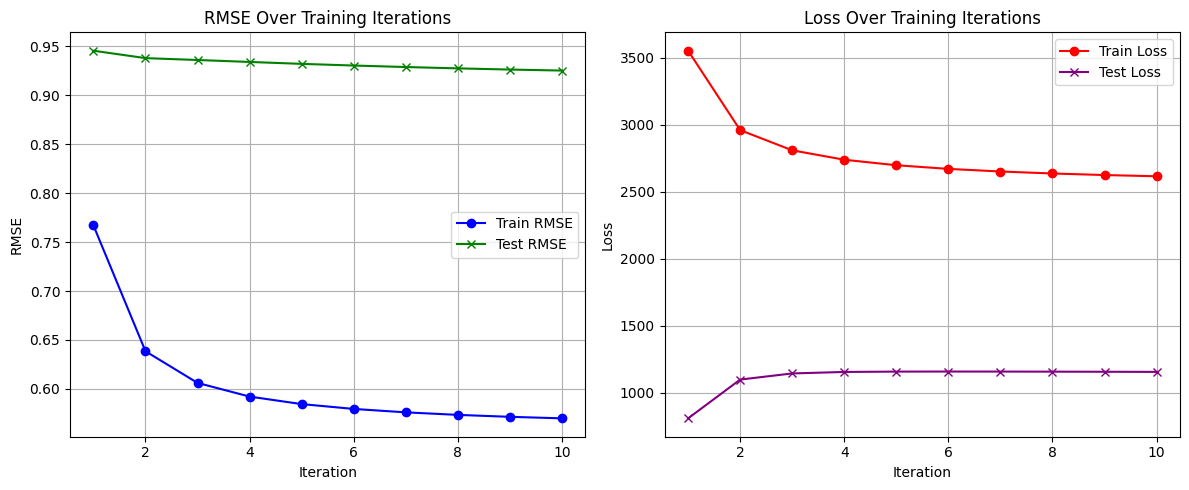

In [ ]:
iterations = list(range(1, len(train_rmses) + 1))

# Set up the figure and the subplots
plt.figure(figsize=(12, 5))  # Adjust figure size to a reasonable dimension for two plots

# Plotting the Train and Test RMSE over iterations
plt.subplot(1, 2, 1)  # Using 1 row, 2 columns, position 1
plt.plot(iterations, train_rmses, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.plot(iterations, test_rmses, marker='x', linestyle='-', color='green', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')
plt.legend()
plt.grid(True)

# Plotting the Train and Test Loss over iterations
plt.subplot(1, 2, 2)  # Using 1 row, 2 columns, position 2
plt.plot(iterations, train_losses, marker='o', linestyle='-', color='red', label='Train Loss')
plt.plot(iterations, test_losses, marker='x', linestyle='-', color='purple', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')
plt.legend()
plt.grid(True)  # Optional, adds grid for better readability

plt.tight_layout()
plt.show()

## Exploring the influence of k (number of latent dimensions)

Evaluating k = 5
Iteration 1, Train RMSE: 0.7856, Test RMSE: 0.9458, Train Loss: 3620.1967, Test Loss: 735.4795
Iteration 2, Train RMSE: 0.6999, Test RMSE: 0.9311, Train Loss: 3190.2933, Test Loss: 924.7482
Iteration 3, Train RMSE: 0.6754, Test RMSE: 0.9245, Train Loss: 3065.1114, Test Loss: 962.4452
Iteration 4, Train RMSE: 0.6645, Test RMSE: 0.9211, Train Loss: 3003.2872, Test Loss: 971.5866
Iteration 5, Train RMSE: 0.6587, Test RMSE: 0.9198, Train Loss: 2967.7486, Test Loss: 972.7408
Iteration 6, Train RMSE: 0.6553, Test RMSE: 0.9194, Train Loss: 2944.9800, Test Loss: 971.6604
Iteration 7, Train RMSE: 0.6531, Test RMSE: 0.9193, Train Loss: 2929.1487, Test Loss: 970.0636
Iteration 8, Train RMSE: 0.6516, Test RMSE: 0.9192, Train Loss: 2917.4856, Test Loss: 968.3889
Iteration 9, Train RMSE: 0.6504, Test RMSE: 0.9191, Train Loss: 2908.4658, Test Loss: 966.7681
Iteration 10, Train RMSE: 0.6495, Test RMSE: 0.9190, Train Loss: 2901.1870, Test Loss: 965.2649
k = 5, Final RMSE = 0.9190221591

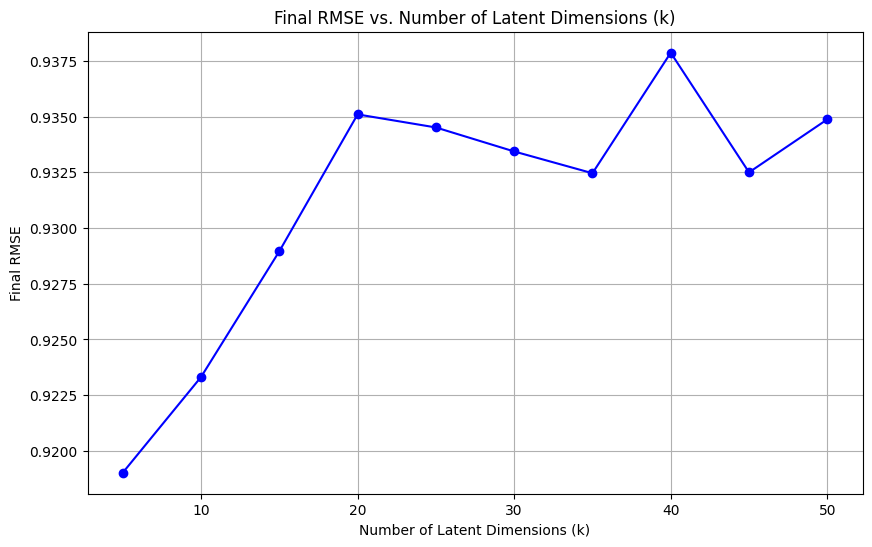


Final RMSE values for each k:
k = 5: Final RMSE = 0.9190221591124949
k = 10: Final RMSE = 0.9233157742669831
k = 15: Final RMSE = 0.928956625394525
k = 20: Final RMSE = 0.9350975805198514
k = 25: Final RMSE = 0.934512204292705
k = 30: Final RMSE = 0.9334350604168373
k = 35: Final RMSE = 0.9324586797683826
k = 40: Final RMSE = 0.9378650290771626
k = 45: Final RMSE = 0.9324977091434818
k = 50: Final RMSE = 0.9348752782537127
Improvement from k=5 to k=10: -0.004293615154488228
Diminishing returns observed at k = 10


In [ ]:
# Best hyperparameters found previously
lambda_reg = 0.1
gamma_latent = 0.5
gamma_bias = 0.1
epochs = 10

# Range of latent dimensions to evaluate
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Lists to store results
final_rmses = []

for k in k_values:
    print(f"Evaluating k = {k}")
    user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
        train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
        epochs, k, lambda_reg, gamma_latent, gamma_bias
    )
    final_rmse = test_rmses[-1]  # Take the last RMSE value
    final_rmses.append(final_rmse)
    print(f"k = {k}, Final RMSE = {final_rmse}")

# Plotting RMSE vs. Latent Dimensions (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, final_rmses, marker='o', linestyle='-', color='b')
plt.title('Final RMSE vs. Number of Latent Dimensions (k)')
plt.xlabel('Number of Latent Dimensions (k)')
plt.ylabel('Final RMSE')
plt.grid(True)
plt.show()

# Print the final RMSE values
print("\nFinal RMSE values for each k:")
for k, rmse in zip(k_values, final_rmses):
    print(f"k = {k}: Final RMSE = {rmse}")

# Identify the point of diminishing returns
for i in range(1, len(final_rmses)):
    improvement = final_rmses[i-1] - final_rmses[i]
    print(f"Improvement from k={k_values[i-1]} to k={k_values[i]}: {improvement}")
    if improvement < 0.001:  # Threshold for diminishing returns
        print(f"Diminishing returns observed at k = {k_values[i]}")
        break

# Training on 25m Movielens dataset

### Loading Data and Creating Index Mappings

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp


### Splitting Data into Training and Test Sets

In [ ]:
# Define the number of last ratings to use as test data
m = 5  # Use last 5 ratings of each user for testing

# Split the data into training and test sets
train_user_ids, train_movie_ids, train_ratings = [], [], []
test_user_ids, test_movie_ids, test_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    if len(ratings) > m:
        # Training data
        for movie_id, rating, _ in ratings[:-m]:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)
        # Test data
        for movie_id, rating, _ in ratings[-m:]:
            test_user_ids.append(user_idx)
            test_movie_ids.append(movie_to_index[movie_id])
            test_ratings.append(rating)
    else:
        # Use all for training if not enough ratings
        for movie_id, rating, _ in ratings:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)

### Handling Cold Start Items

In [ ]:
# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)
test_user_ids = np.array(test_user_ids)
test_movie_ids = np.array(test_movie_ids)
test_ratings = np.array(test_ratings)

# Check for cold start items in the test set
train_movie_set = set(train_movie_ids)
cold_start_indices = [i for i, movie_id in enumerate(test_movie_ids) if movie_id not in train_movie_set]

# Add cold start items to the training set
if cold_start_indices:
    train_user_ids = np.concatenate((train_user_ids, test_user_ids[cold_start_indices]))
    train_movie_ids = np.concatenate((train_movie_ids, test_movie_ids[cold_start_indices]))
    train_ratings = np.concatenate((train_ratings, test_ratings[cold_start_indices]))

### Re-indexing the Data

In [ ]:
# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Remap test user and movie indices
indexed_test_user_ids = np.array([train_user_to_index.get(uid, -1) for uid in test_user_ids])
indexed_test_movie_ids = np.array([train_movie_to_index.get(mid, -1) for mid in test_movie_ids])

# Filter valid test indices to ensure they are known in the training set
valid_test_indices = (indexed_test_user_ids != -1) & (indexed_test_movie_ids != -1)

test_user_ids = indexed_test_user_ids[valid_test_indices]
test_movie_ids = indexed_test_movie_ids[valid_test_indices]
test_ratings = test_ratings[valid_test_indices]

# Output the shapes of the training and test sets
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)
print("Test data:", test_user_ids.shape, test_movie_ids.shape, test_ratings.shape)

# Report the number of cold start items
total_test_items = len(test_movie_ids)
removed_count = len(cold_start_indices)
print(f"Total test items: {total_test_items}")
print(f"Cold start items added to training set: {removed_count}")
print(f"Percentage of cold start items: {removed_count / total_test_items * 100:.2f}%")

Training data: (24187673,) (24187673,) (24187673,)
Test data: (812705,) (812705,) (812705,)
Total test items: 812705
Cold start items added to training set: 283
Percentage of cold start items: 0.03%


## Update ALS code with Batch Processing and GPU computations for training in Google Colab

In [ ]:
import torch

def initialize_factors(user_ids, movie_ids, num_factors):
    num_users = len(torch.unique(user_ids.cpu()))
    num_movies = len(torch.unique(movie_ids.cpu()))
    user_bias = torch.zeros(num_users, device=device)
    item_bias = torch.zeros(num_movies, device=device)
    user_factors = torch.randn(num_users, num_factors, device=device) * 0.1
    item_factors = torch.randn(num_movies, num_factors, device=device) * 0.1
    return user_bias, item_bias, user_factors, item_factors

def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + torch.sum(user_factors[user_ids] * item_factors[movie_ids], dim=1)
    errors = ratings - predictions
    loss = 0.5 * torch.sum(errors**2)
    regularization_bias = 0.5 * gamma_bias * (torch.sum(user_bias**2) + torch.sum(item_bias**2))
    regularization_factors = 0.5 * gamma_latent * (torch.sum(user_factors**2) + torch.sum(item_factors**2))
    return lambda_reg * loss + regularization_bias + regularization_factors

def calculate_rmse(predictions, ratings):
    mse = torch.mean((predictions - ratings) ** 2)
    return torch.sqrt(mse)

def predict_rating(user_ids, movie_ids, user_bias, item_bias, user_factors, item_factors):
    dot_products = torch.sum(user_factors[user_ids] * item_factors[movie_ids], dim=1)
    predictions = user_bias[user_ids] + item_bias[movie_ids] + dot_products
    return predictions

In [ ]:
def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    unique_user_ids = torch.unique(user_ids)
    for user_id in unique_user_ids:
        indices = (user_ids == user_id).nonzero(as_tuple=True)[0]
        item_indices = movie_ids[indices]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[item_indices]
        user_factor = user_factors[user_id]
        item_factors_subset = item_factors[item_indices]

        num_items = len(indices)
        dot_product = torch.sum(item_factors_subset * user_factor, dim=1)

        numerator = lambda_reg * torch.sum(ratings_subset - item_bias_subset - dot_product)
        denominator = lambda_reg * num_items + gamma_bias
        user_bias[user_id] = numerator / denominator

    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    unique_movie_ids = torch.unique(movie_ids)
    for movie_id in unique_movie_ids:
        indices = (movie_ids == movie_id).nonzero(as_tuple=True)[0]
        user_indices = user_ids[indices]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_indices]
        item_factor = item_factors[movie_id]
        user_factors_subset = user_factors[user_indices]

        num_users = len(indices)
        dot_product = torch.sum(user_factors_subset * item_factor, dim=1)

        numerator = lambda_reg * torch.sum(ratings_subset - user_bias_subset - dot_product)
        denominator = lambda_reg * num_users + gamma_bias
        item_bias[movie_id] = numerator / denominator

    return item_bias

In [ ]:
def update_user_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    unique_user_ids = torch.unique(user_ids)
    for user_id in unique_user_ids:
        indices = (user_ids == user_id).nonzero(as_tuple=True)[0]
        V_i = item_factors[movie_ids[indices]]
        A = lambda_reg * torch.mm(V_i.t(), V_i) + gamma_latent * torch.eye(V_i.size(1), device=device)
        residuals = ratings[indices] - user_bias[user_id] - item_bias[movie_ids[indices]]
        b = lambda_reg * torch.sum(residuals[:, None] * V_i, dim=0)
        user_factors[user_id] = torch.linalg.solve(A, b)

    return user_factors

def update_item_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    unique_movie_ids = torch.unique(movie_ids)
    for movie_id in unique_movie_ids:
        indices = (movie_ids == movie_id).nonzero(as_tuple=True)[0]
        U_j = user_factors[user_ids[indices]]
        A = lambda_reg * torch.mm(U_j.t(), U_j) + gamma_latent * torch.eye(U_j.size(1), device=device)
        residuals = ratings[indices] - user_bias[user_ids[indices]] - item_bias[movie_id]
        b = lambda_reg * torch.sum(residuals[:, None] * U_j, dim=0)
        item_factors[movie_id] = torch.linalg.solve(A, b)

    return item_factors

In [ ]:
def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings, iterations, num_factors, lambda_reg, gamma_latent, gamma_bias):
    user_bias, item_bias, user_factors, item_factors = initialize_factors(train_user_ids, train_movie_ids, num_factors)
    train_rmses = []
    test_rmses = []
    train_losses = []
    test_losses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)

        user_factors = update_user_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        item_factors = update_item_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)

        torch.cuda.empty_cache()  # Clear cached memory

        # Compute predictions and RMSE for training set
        train_predictions = predict_rating(train_user_ids, train_movie_ids, user_bias, item_bias, user_factors, item_factors)
        train_rmse = calculate_rmse(train_predictions, train_ratings)
        train_rmses.append(train_rmse)
        train_loss = calculate_loss(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        train_losses.append(train_loss)

        # Compute predictions and RMSE for test set with torch.no_grad to save memory
        with torch.no_grad():
            test_predictions = predict_rating(test_user_ids, test_movie_ids, user_bias, item_bias, user_factors, item_factors)
            test_rmse = calculate_rmse(test_predictions, test_ratings)
            test_rmses.append(test_rmse)
            test_loss = calculate_loss(test_user_ids, test_movie_ids, test_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
            test_losses.append(test_loss)

        print(f"Iteration {iteration + 1}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses

## Training on 25m Dataset

In [ ]:
# Example usage with GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to torch tensors and move them to GPU with the correct precision
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device='cuda')
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device='cuda')
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')
test_user_ids = torch.tensor(test_user_ids, dtype=torch.long, device='cuda')
test_movie_ids = torch.tensor(test_movie_ids, dtype=torch.long, device='cuda')
test_ratings = torch.tensor(test_ratings, dtype=torch.float32, device='cuda')

# Number of epochs
epochs = 10

# Hyperparameters
k = 10 # Number of latent dimensions
lambda_reg = 0.1 # Error scaling factor
gamma_latent = 0.5     # Regularization parameter for latent factor vectors
gamma_bias = 0.1     # Regularization parameter for biases

# Final model training with the best parameters
user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
    epochs, k, lambda_reg, gamma_latent, gamma_bias
)

Iteration 1, Train RMSE: 0.8344, Test RMSE: 0.9458, Train Loss: 960517.9375, Test Loss: 154810.3438
Iteration 2, Train RMSE: 0.7672, Test RMSE: 0.9102, Train Loss: 838113.6250, Test Loss: 160019.3594
Iteration 3, Train RMSE: 0.7388, Test RMSE: 0.8898, Train Loss: 785079.3125, Test Loss: 157049.9531
Iteration 4, Train RMSE: 0.7267, Test RMSE: 0.8826, Train Loss: 761162.4375, Test Loss: 154071.6406
Iteration 5, Train RMSE: 0.7213, Test RMSE: 0.8808, Train Loss: 749053.1250, Test Loss: 151445.1562
Iteration 6, Train RMSE: 0.7184, Test RMSE: 0.8811, Train Loss: 741741.5000, Test Loss: 149099.1250
Iteration 7, Train RMSE: 0.7168, Test RMSE: 0.8821, Train Loss: 736693.2500, Test Loss: 146969.5312
Iteration 8, Train RMSE: 0.7158, Test RMSE: 0.8835, Train Loss: 732891.8125, Test Loss: 145016.3750
Iteration 9, Train RMSE: 0.7151, Test RMSE: 0.8850, Train Loss: 729853.5000, Test Loss: 143212.0312
Iteration 10, Train RMSE: 0.7147, Test RMSE: 0.8864, Train Loss: 727316.3750, Test Loss: 141534.4844

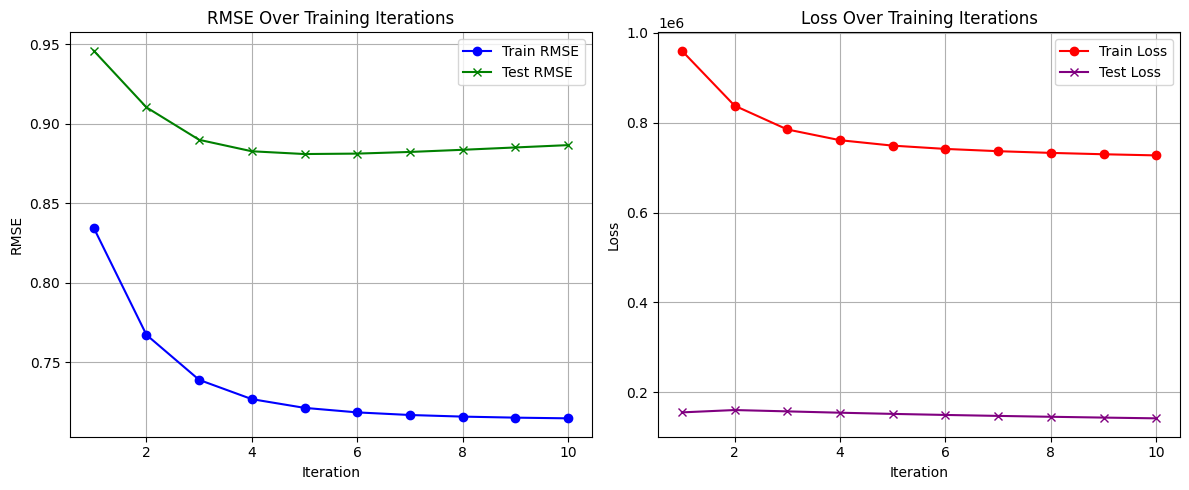

In [ ]:
iterations = list(range(1, len(train_rmses) + 1))

# Move tensors from GPU to CPU and convert them to numpy arrays
train_rmses_cpu = [rmse.cpu().numpy() for rmse in train_rmses]
test_rmses_cpu = [rmse.cpu().numpy() for rmse in test_rmses]
train_losses_cpu = [loss.cpu().numpy() for loss in train_losses]
test_losses_cpu = [loss.cpu().numpy() for loss in test_losses]

# Set up the figure and the subplots
plt.figure(figsize=(12, 5))  # Adjust figure size to a reasonable dimension for two plots

# Plotting the Train and Test RMSE over iterations
plt.subplot(1, 2, 1)  # Using 1 row, 2 columns, position 1
plt.plot(iterations, train_rmses_cpu, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.plot(iterations, test_rmses_cpu, marker='x', linestyle='-', color='green', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')
plt.legend()
plt.grid(True)

# Plotting the Train and Test Loss over iterations
plt.subplot(1, 2, 2)  # Using 1 row, 2 columns, position 2
plt.plot(iterations, train_losses_cpu, marker='o', linestyle='-', color='red', label='Train Loss')
plt.plot(iterations, test_losses_cpu, marker='x', linestyle='-', color='purple', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')
plt.legend()
plt.grid(True)  # Optional, adds grid for better readability

plt.tight_layout()
plt.show()


We can see that we start to overfit after about 5 epochs

## Final Model Training with Full 25M dataset

### Data preprocessing with only training set

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp

# Prepare the training data
train_user_ids, train_movie_ids, train_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    for movie_id, rating, _ in ratings:
        train_user_ids.append(user_idx)
        train_movie_ids.append(movie_to_index[movie_id])
        train_ratings.append(rating)

# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)

# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Output the shapes of the training set
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)

Training data: (25000095,) (25000095,) (25000095,)


## Code to save model parameters during training

In [ ]:
def save_model(epoch, user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses, directory):
    model_state = {
        'epoch': epoch,
        'user_bias': user_bias.cpu(),
        'item_bias': item_bias.cpu(),
        'user_factors': user_factors.cpu(),
        'item_factors': item_factors.cpu(),
        'train_rmses': train_rmses,
        'train_losses': train_losses,
    }
    file_path = os.path.join(directory, f"model_checkpoint_epoch_{epoch}.pth")
    torch.save(model_state, file_path)

## Updated ALS function code

In [ ]:
def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, epochs, num_factors, lambda_reg, gamma_latent, gamma_bias, checkpoint_dir):
    device = train_user_ids.device  # Assuming all tensors are on the same device

    user_bias, item_bias, user_factors, item_factors = initialize_factors(train_user_ids, train_movie_ids, num_factors)
    train_rmses = []
    train_losses = []

    for epoch in range(epochs):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)

        user_factors = update_user_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        item_factors = update_item_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)

        # Compute RMSE for training set
        train_predictions = predict_rating(train_user_ids, train_movie_ids, user_bias, item_bias, user_factors, item_factors)
        train_rmse = calculate_rmse(train_predictions, train_ratings)
        train_rmses.append(train_rmse)
        train_loss = calculate_loss(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}, Train RMSE: {train_rmse:.4f}, Train Loss: {train_loss:.4f}")

        # Save the model after each epoch
        save_model(epoch, user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses, checkpoint_dir)
    return user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses

## Use full 25M dataset to train the model

In [ ]:
import os

# Example usage with GPU
# Convert data to torch tensors and move them to GPU with the correct precision
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device='cuda')
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device='cuda')
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')

# Hyperparameters
epochs = 5 # It was revealed that after 5 epochs, the model starts to overfit
k = 10  # Number of latent dimensions
lambda_reg = 0.1  # Error scaling factor
gamma_latent = 0.5  # Regularization parameter for latent factor vectors
gamma_bias = 0.1  # Regularization parameter for biases


# Create a directory in Google Drive
checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints_full_als_model'
os.makedirs(checkpoint_dir, exist_ok=True)

# Train the model using ALS
user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings,
    epochs, k, lambda_reg, gamma_latent, gamma_bias, checkpoint_dir
)

# Output final RMSE
final_rmse = train_rmses[-1]
print(f"Final Train RMSE: {final_rmse:.4f}")

<ipython-input-20-a8d4ec113144>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')


Epoch 1, Train RMSE: 0.8374, Train Loss: 996238.5000
Epoch 2, Train RMSE: 0.7687, Train Loss: 866974.2500
Epoch 3, Train RMSE: 0.7412, Train Loss: 814041.5625
Epoch 4, Train RMSE: 0.7293, Train Loss: 789906.8125
Epoch 5, Train RMSE: 0.7235, Train Loss: 776904.6250
Final Train RMSE: 0.7235


## Plot results

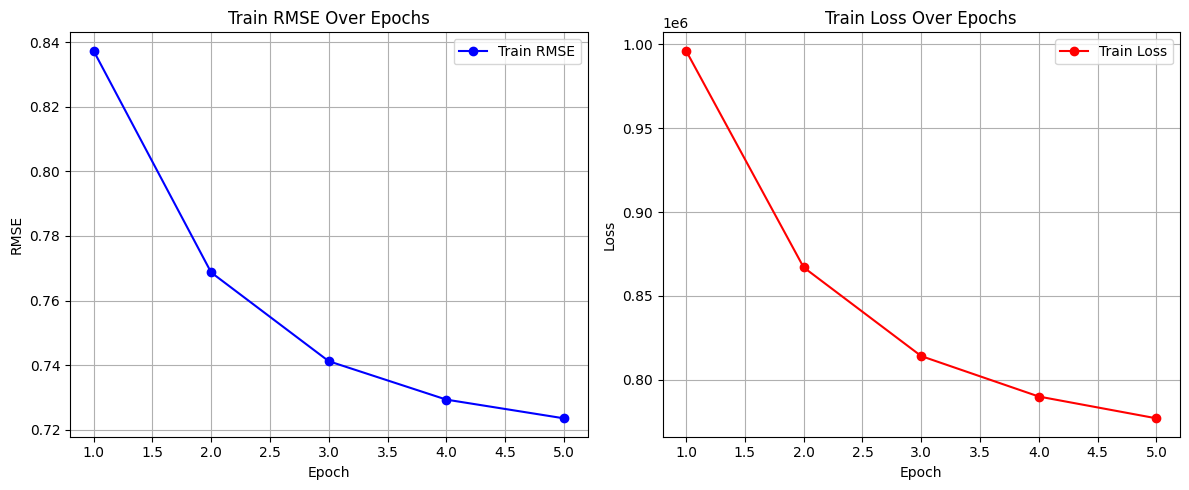

In [ ]:
# Given values
iterations = [1, 2, 3, 4, 5]
train_rmses = [0.8374, 0.7687, 0.7412, 0.7293, 0.7235]
train_losses = [996238.5000, 866974.2500, 814041.5625, 789906.8125, 776904.6250]

# Plotting the Train RMSE over iterations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(iterations, train_rmses, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train RMSE Over Epochs')
plt.grid(True)
plt.legend()

# Plotting the Train Loss over iterations
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(iterations, train_losses, marker='o', linestyle='-', color='red', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Visualizing Embeddings in 2D

## First we have to train the model with latent dimensions equal to 2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert your data to torch tensors and move them to GPU with the correct precision
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device='cuda')
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device='cuda')
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')

# Hyperparameters
epochs = 5 # It was revealed that after 5 epochs, the model starts to overfit
k = 2  # Number of latent dimensions
lambda_reg = 0.1  # Error scaling factor
gamma_latent = 0.5  # Regularization parameter for latent factor vectors
gamma_bias = 0.1  # Regularization parameter for biases


# Create a directory in Google Drive
checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints_2D_full_als_model'
os.makedirs(checkpoint_dir, exist_ok=True)

# Train the model using ALS
user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings,
    epochs, k, lambda_reg, gamma_latent, gamma_bias, checkpoint_dir
)

# Output final RMSE
final_rmse = train_rmses[-1]
print(f"Final Train RMSE: {final_rmse:.4f}")

<ipython-input-19-eed61e6a79c1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device='cuda')


Epoch 1, Train RMSE: 0.8590, Train Loss: 1033266.6875
Epoch 2, Train RMSE: 0.8196, Train Loss: 951063.8750
Epoch 3, Train RMSE: 0.8048, Train Loss: 920151.6250
Epoch 4, Train RMSE: 0.7999, Train Loss: 908251.0625
Epoch 5, Train RMSE: 0.7977, Train Loss: 902238.5625
Final Train RMSE: 0.7977


## Load model weights

In [ ]:
def load_model(file_path, device):
    model_state = torch.load(file_path)
    epoch = model_state['epoch']
    user_bias = model_state['user_bias'].to(device)
    item_bias = model_state['item_bias'].to(device)
    user_factors = model_state['user_factors'].to(device)
    item_factors = model_state['item_factors'].to(device)
    train_rmses = model_state['train_rmses']
    return epoch, user_bias, item_bias, user_factors, item_factors, train_rmses

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path to the checkpoint file
checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints_2D_full_als_model'
latest_checkpoint_file = os.path.join(checkpoint_dir, 'model_checkpoint_epoch_4.pth')  # Adjust the epoch number as needed

# Load the model state
last_epoch, user_bias, item_bias, user_factors, item_factors, train_rmses = load_model(latest_checkpoint_file, device)

<ipython-input-8-335a7e205dc3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(file_path)


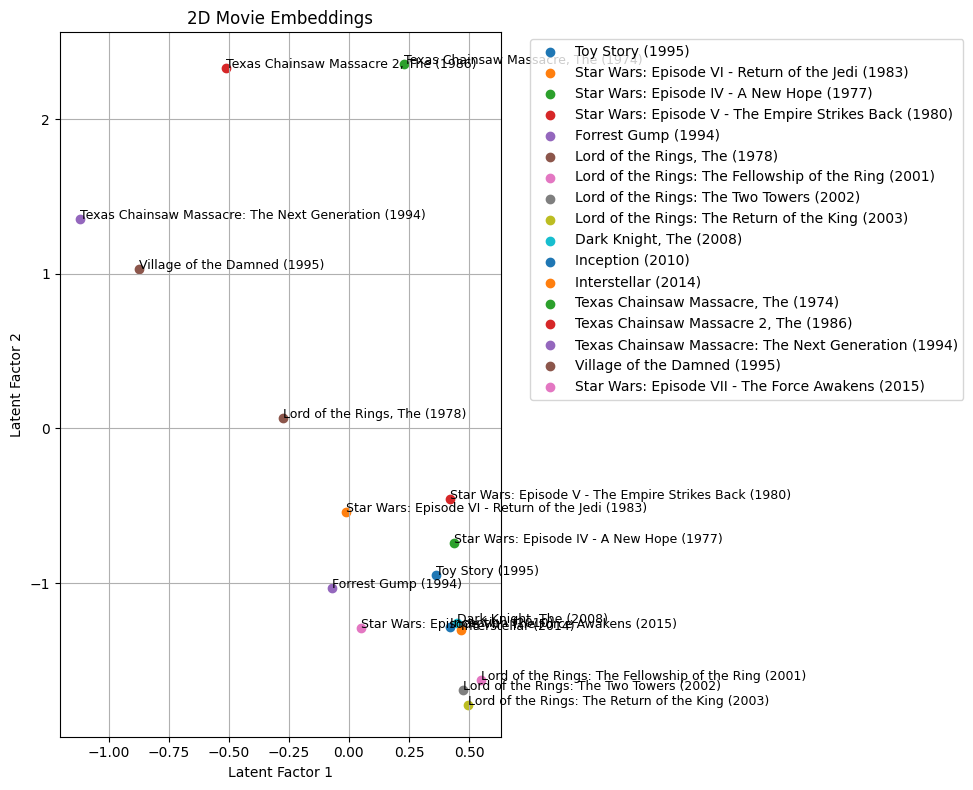

Movie Positions in 2D Latent Space:
Toy Story (1995): Position = (0.36, -0.95)
Star Wars: Episode VI - Return of the Jedi (1983): Position = (-0.01, -0.54)
Star Wars: Episode IV - A New Hope (1977): Position = (0.44, -0.74)
Star Wars: Episode V - The Empire Strikes Back (1980): Position = (0.42, -0.46)
Forrest Gump (1994): Position = (-0.07, -1.03)
Lord of the Rings, The (1978): Position = (-0.28, 0.06)
Lord of the Rings: The Fellowship of the Ring (2001): Position = (0.55, -1.63)
Lord of the Rings: The Two Towers (2002): Position = (0.48, -1.69)
Lord of the Rings: The Return of the King (2003): Position = (0.50, -1.79)
Dark Knight, The (2008): Position = (0.45, -1.26)
Inception (2010): Position = (0.42, -1.29)
Interstellar (2014): Position = (0.47, -1.30)
Texas Chainsaw Massacre, The (1974): Position = (0.23, 2.35)
Texas Chainsaw Massacre 2, The (1986): Position = (-0.51, 2.33)
Texas Chainsaw Massacre: The Next Generation (1994): Position = (-1.12, 1.35)
Village of the Damned (1995): 

In [ ]:
# Example movie IDs (ensure these are in your indexed data)
movie_ids_to_plot = [1, 1210, 260, 1196, 356, 2116, 4993, 5952, 7153, 58559, 79132, 109487, 2459, 2460, 2462, 332, 122886]  # Toy Story, Star Wars, Forrest Gump, LOTR, etc.

# Map movie IDs to titles if you have that information
movie_titles = {
    1: "Toy Story (1995)",
    1210: "Star Wars: Episode VI - Return of the Jedi (1983)",
    260: "Star Wars: Episode IV - A New Hope (1977)",
    1196: "Star Wars: Episode V - The Empire Strikes Back (1980)",
    356: "Forrest Gump (1994)",
    2116: "Lord of the Rings, The (1978)",
    4993: "Lord of the Rings: The Fellowship of the Ring (2001)",
    5952: "Lord of the Rings: The Two Towers (2002)",
    7153: "Lord of the Rings: The Return of the King (2003)",
    58559: "Dark Knight, The (2008)",
    79132: "Inception (2010)",
    109487: "Interstellar (2014)",
    2459: "Texas Chainsaw Massacre, The (1974)",
    2460: "Texas Chainsaw Massacre 2, The (1986)",
    2462: "Texas Chainsaw Massacre: The Next Generation (1994)",
    332: "Village of the Damned (1995)",
    122886: "Star Wars: Episode VII - The Force Awakens (2015)"
}

# Get the indices for the movies to plot
indices_to_plot = [movie_to_index[movie_id] for movie_id in movie_ids_to_plot if movie_id in movie_to_index]

# Extract the 2D vectors for the selected movies
vectors = item_factors[indices_to_plot].cpu().numpy()  # Move to CPU and convert to numpy

# Plotting
plt.figure(figsize=(10, 8))
for i, movie_id in enumerate(movie_ids_to_plot):
    if movie_id in movie_to_index:
        plt.scatter(vectors[i, 0], vectors[i, 1], label=movie_titles.get(movie_id, f"Movie {movie_id}"))
        plt.text(vectors[i, 0], vectors[i, 1], movie_titles.get(movie_id, f"Movie {movie_id}"), fontsize=9)

plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.title("2D Movie Embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Prevents overlap
plt.show()

# Print the positions
print("Movie Positions in 2D Latent Space:")
for i, movie_id in enumerate(movie_ids_to_plot):
    if movie_id in movie_to_index:
        x, y = vectors[i, 0], vectors[i, 1]
        print(f"{movie_titles[movie_id]}: Position = ({x:.2f}, {y:.2f})")
    else:
        print(f"{movie_titles[movie_id]}: Position = Not available (Movie ID not in training set)")

# Adding a dummy user and getting recommendations

### Load saved model for predictions

In [ ]:
def load_model(file_path, device):
    model_state = torch.load(file_path)
    epoch = model_state['epoch']
    user_bias = model_state['user_bias'].to(device)
    item_bias = model_state['item_bias'].to(device)
    user_factors = model_state['user_factors'].to(device)
    item_factors = model_state['item_factors'].to(device)
    train_rmses = model_state['train_rmses']
    return epoch, user_bias, item_bias, user_factors, item_factors, train_rmses

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path to the checkpoint file
checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints_full_als_model'
latest_checkpoint_file = os.path.join(checkpoint_dir, 'model_checkpoint_epoch_4.pth')  # Adjust the epoch number as needed

# Load the model state
last_epoch, user_bias, item_bias, user_factors, item_factors, train_rmses = load_model(latest_checkpoint_file, device)

<ipython-input-31-e09354ef13ca>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(file_path)


## Loading Movie IDs and Movie Title Names

In [ ]:
movie_id_to_title = {}
title_to_movie_id = {}

# Load movies data from CSV file
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/movies.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        movie_id = int(row[0])
        title = row[1].strip().lower()  # Use lowercase and strip extra spaces for case-insensitive search
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Adding a dummy user and making prediction

In [ ]:
# Helper function to get the movie index using partial matching
def get_movie_index(movie_name, title_to_movie_id):
    movie_name_lower = movie_name.strip().lower()  # Handle case sensitivity and extra spaces
    matching_titles = [movie_id for title, movie_id in title_to_movie_id.items() if movie_name_lower in title]

    if len(matching_titles) == 1:
        return matching_titles[0]
    elif len(matching_titles) > 1:
        print(f"Multiple matches found for '{movie_name}': {[movie_id_to_title[movie_id] for movie_id in matching_titles]}")
        return matching_titles[0]  # Return the first match, or implement logic to select the best match
    else:
        return None

# Initialize Dummy User Factors
def initialize_dummy_user_factors(num_factors):
    dummy_user_factors = torch.randn(1, num_factors, device=device) * 0.4
    return dummy_user_factors

# Update Dummy User Factors
def update_dummy_user_factors(dummy_user_factors, item_factors, movie_index, rating, iterations=10, learning_rate=0.01):
    item_factor = item_factors[movie_index].unsqueeze(0)  # Ensure correct shape
    for _ in range(iterations):
        dot_product = torch.sum(dummy_user_factors * item_factor, dim=1)
        error = rating - dot_product
        dummy_user_factors += learning_rate * (error[:, None] * item_factor)
    return dummy_user_factors

# Generate Recommendations
def recommend_top_n(dummy_user_factors, item_factors, item_bias, top_n=5):
    scores = torch.sum(dummy_user_factors * item_factors, dim=1) + 0.05 * item_bias
    top_n_indices = torch.topk(scores, top_n * 2).indices  # Fetch more than needed in case of invalid ones
    return top_n_indices

# Create a reverse mapping from index to original movie ID
index_to_movie_id = {idx: mid for mid, idx in train_movie_to_index.items()}

# Example usage
movie_name = "harry potter"  # This is a partial title, and we want to match it to a full title
movie_id = get_movie_index(movie_name, title_to_movie_id)
if movie_id is None:
    raise ValueError(f"Movie '{movie_name}' not found in the dataset.")

# Assuming you have train_movie_to_index mapping
movie_index = train_movie_to_index[movie_id]

rating = 5.0  # High rating for the movie

# Initialize dummy user factors
dummy_user_factors = initialize_dummy_user_factors(user_factors.shape[1])

# Update dummy user factors
dummy_user_factors = update_dummy_user_factors(dummy_user_factors, item_factors, movie_index, rating, iterations=10, learning_rate=0.01)

# Generate top N recommendations
top_n_indices = recommend_top_n(dummy_user_factors, item_factors, item_bias, top_n=5)

valid_recommendations = []
for idx in top_n_indices:
    original_movie_id = index_to_movie_id[idx.item()]
    if original_movie_id is not None and original_movie_id in movie_id_to_title:
        valid_recommendations.append((original_movie_id, movie_id_to_title[original_movie_id]))
    if len(valid_recommendations) == 10:
        break  # Stop when we have enough valid recommendations

# Print out the valid recommendations
print("Top recommendations for a dummy user who liked", movie_name, ":")
for movie_id, title in valid_recommendations:
    print(f"Recommended Movie ID: {movie_id} - {title}")

Multiple matches found for 'harry potter': ["harry potter and the sorcerer's stone (a.k.a. harry potter and the philosopher's stone) (2001)", 'harry potter and the chamber of secrets (2002)', 'harry potter and the prisoner of azkaban (2004)', 'harry potter and the goblet of fire (2005)', 'harry potter and the order of the phoenix (2007)', 'harry potter and the half-blood prince (2009)', 'harry potter and the deathly hallows: part 1 (2010)', 'harry potter and the deathly hallows: part 2 (2011)', 'the greater good - harry potter fan film (2013)']
Top recommendations for a dummy user who liked harry potter :
Recommended Movie ID: 4872 - intimacy (2000)
Recommended Movie ID: 2589 - friends & lovers (1999)
Recommended Movie ID: 3318 - deterrence (1999)
Recommended Movie ID: 4903 - in the bedroom (2001)
Recommended Movie ID: 3328 - ghost dog: the way of the samurai (1999)
Recommended Movie ID: 4942 - angry red planet, the (1959)
Recommended Movie ID: 3327 - beyond the mat (1999)
Recommended 

# Finding out which movies are polarizing

In [ ]:
def calculate_latent_vector_magnitudes(item_factors):
    # Calculate the magnitude (norm) of each latent factor vector
    magnitudes = torch.norm(item_factors, dim=1)
    return magnitudes

def find_polarizing_movies_with_titles(item_factors, movie_to_index, movie_id_to_title, top_n=10):
    # Calculate the magnitude of the latent vectors
    magnitudes = calculate_latent_vector_magnitudes(item_factors)

    # Find the indices of the top N most polarizing movies (with the largest magnitudes)
    top_n_indices = torch.topk(magnitudes, top_n).indices

    # Map these indices back to the original movie IDs and titles
    polarizing_movies = []
    for idx in top_n_indices:
        # Map the index to the original movie ID
        for movie_id, index in movie_to_index.items():
            if index == idx.item():
                title = movie_id_to_title.get(movie_id, f"Movie ID {movie_id}")
                polarizing_movies.append((movie_id, title, magnitudes[idx.item()].item()))
                break

    return polarizing_movies

# Example usage:
top_n_polarizing_movies = find_polarizing_movies_with_titles(item_factors, movie_to_index, movie_id_to_title, top_n=10)

# Print the most polarizing movies with titles and magnitudes
print("Most Polarizing Movies:")
for movie_id, title, magnitude in top_n_polarizing_movies:
    print(f"Movie ID: {movie_id}, Title: {title}, Magnitude: {magnitude:.4f}")


Most Polarizing Movies:
Movie ID: 231, Title: dumb & dumber (dumb and dumber) (1994), Magnitude: 5.2073
Movie ID: 344, Title: ace ventura: pet detective (1994), Magnitude: 4.5013
Movie ID: 288, Title: natural born killers (1994), Magnitude: 4.3714
Movie ID: 78772, Title: twilight saga: eclipse, the (2010), Magnitude: 4.3615
Movie ID: 19, Title: ace ventura: when nature calls (1995), Magnitude: 4.3357
Movie ID: 91104, Title: twilight saga: breaking dawn - part 1, the (2011), Magnitude: 4.2973
Movie ID: 72407, Title: twilight saga: new moon, the (2009), Magnitude: 4.2417
Movie ID: 98203, Title: twilight saga: breaking dawn - part 2, the (2012), Magnitude: 4.2396
Movie ID: 63992, Title: twilight (2008), Magnitude: 4.1056
Movie ID: 7153, Title: lord of the rings: the return of the king, the (2003), Magnitude: 3.9309


In [ ]:
def calculate_latent_vector_magnitudes(item_factors):
    # Calculate the magnitude (norm) of each latent factor vector
    magnitudes = torch.norm(item_factors, dim=1)
    return magnitudes

def find_least_polarizing_movies(item_factors, movie_to_index, top_n=10):
    magnitudes = calculate_latent_vector_magnitudes(item_factors)
    bottom_n_indices = torch.topk(magnitudes, top_n, largest=False).indices
    return bottom_n_indices, magnitudes

# Example implementation
top_n_least_polarizing_indices, magnitudes = find_least_polarizing_movies(item_factors, movie_to_index, top_n=10)

# Print the least polarizing movies with a fallback for unknown titles
print("Least Polarizing Movies:")
for idx in top_n_least_polarizing_indices:
    movie_id = idx.item()
    movie_title = movie_id_to_title.get(movie_id, f"Unknown Title (Movie ID: {movie_id})")
    magnitude = magnitudes[idx].item()
    print(f"Movie ID: {movie_id}, Title: {movie_title}, Magnitude: {magnitude:.4f}")


Least Polarizing Movies:
Movie ID: 39836, Title: Unknown Title (Movie ID: 39836), Magnitude: 0.0000
Movie ID: 39808, Title: Unknown Title (Movie ID: 39808), Magnitude: 0.0000
Movie ID: 35014, Title: Unknown Title (Movie ID: 35014), Magnitude: 0.0000
Movie ID: 55293, Title: Unknown Title (Movie ID: 55293), Magnitude: 0.0000
Movie ID: 55287, Title: Unknown Title (Movie ID: 55287), Magnitude: 0.0000
Movie ID: 58982, Title: Unknown Title (Movie ID: 58982), Magnitude: 0.0001
Movie ID: 58364, Title: Unknown Title (Movie ID: 58364), Magnitude: 0.0001
Movie ID: 55074, Title: Unknown Title (Movie ID: 55074), Magnitude: 0.0001
Movie ID: 42105, Title: Unknown Title (Movie ID: 42105), Magnitude: 0.0001
Movie ID: 53600, Title: in your hands (forbrydelser) (2004), Magnitude: 0.0001


# Simulated A/B testing

In [ ]:
# Initialize Dummy User Factors
def initialize_dummy_user_factors(num_factors):
    dummy_user_factors = torch.randn(1, num_factors, device=device) * 0.1
    return dummy_user_factors

# Update Dummy User Factors
def update_dummy_user_factors(dummy_user_factors, item_factors, movie_index, rating, iterations=10, learning_rate=0.01):
    item_factor = item_factors[movie_index].unsqueeze(0)  # Ensure correct shape
    for _ in range(iterations):
        dot_product = torch.sum(dummy_user_factors * item_factor, dim=1)
        error = rating - dot_product
        dummy_user_factors += learning_rate * (error[:, None] * item_factor)
    return dummy_user_factors

# Generate Recommendations
def recommend_top_n(dummy_user_factors, item_factors, item_bias, top_n=10, downplay_bias=False):
    if downplay_bias:
        scores = torch.sum(dummy_user_factors * item_factors, dim=1) + 1 * item_bias  # Original setting
    else:
        scores = torch.sum(dummy_user_factors * item_factors, dim=1) + 0.05 * item_bias # Downplay item bias

    top_n_indices = torch.topk(scores, top_n * 2).indices  # Fetch more than needed in case of invalid ones
    return top_n_indices

# Example usage with feedback simulation and logging
def createreco(userid, versionid, num_factors, top_n=10):
    # Initialize dummy user factors
    dummy_user_factors = initialize_dummy_user_factors(num_factors)

    movie_name = "star wars: episode iv - a new hope (1977)"  # Example starting point for the dummy user
    movie_id = get_movie_index(movie_name, title_to_movie_id)
    if movie_id is None:
        raise ValueError(f"Movie '{movie_name}' not found in the dataset.")
    movie_index = train_movie_to_index[movie_id]

    rating = 5.0  # High rating for the movie

    # Update dummy user factors
    dummy_user_factors = update_dummy_user_factors(dummy_user_factors, item_factors, movie_index, rating, iterations=10, learning_rate=0.01)

    # Determine if we should downplay item bias based on the version
    downplay_bias = versionid == 'B'

    # Generate top N recommendations
    top_n_indices = recommend_top_n(dummy_user_factors, item_factors, item_bias, top_n=top_n, downplay_bias=downplay_bias)

    valid_recommendations = []
    for idx in top_n_indices:
        original_movie_id = index_to_movie_id[idx.item()]
        if original_movie_id is not None and original_movie_id in movie_id_to_title:
            valid_recommendations.append((original_movie_id, movie_id_to_title[original_movie_id]))
        if len(valid_recommendations) == top_n:
            break  # Stop when we have enough valid recommendations

    feedback_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/feedback'
    os.makedirs(feedback_dir, exist_ok=True)
    feedback_file = os.path.join(feedback_dir, 'user_feedback.csv')

    # Simulate feedback and log to CSV
    with open(feedback_file, 'a', newline='') as csvfile:
      csvwriter = csv.writer(csvfile)
      for movie_id, title in valid_recommendations:
          feedback = random.choice(['like', 'dislike'])  # Simulate feedback
          csvwriter.writerow([userid, movie_id, feedback, versionid])

    return valid_recommendations

# Simulate A/B testing with 100 dummy users
for user_id in range(100):
    version_id = random.choice(['A', 'B'])
    recommendations = createreco(user_id, version_id, user_factors.shape[1], top_n=10)
    print(f"User {user_id} (Version {version_id}) recommendations:")
    for movie_id, title in recommendations:
        print(f"Recommended Movie ID: {movie_id} - {title}")


User 0 (Version B) recommendations:
Recommended Movie ID: 3039 - trading places (1983)
Recommended Movie ID: 260 - star wars: episode iv - a new hope (1977)
Recommended Movie ID: 275 - mixed nuts (1994)
Recommended Movie ID: 271 - losing isaiah (1995)
Recommended Movie ID: 1204 - lawrence of arabia (1962)
Recommended Movie ID: 1076 - innocents, the (1961)
Recommended Movie ID: 278 - miami rhapsody (1995)
Recommended Movie ID: 1179 - grifters, the (1990)
Recommended Movie ID: 439 - dangerous game (1993)
Recommended Movie ID: 3170 - hi-yo silver (1940)
User 1 (Version A) recommendations:
Recommended Movie ID: 1204 - lawrence of arabia (1962)
Recommended Movie ID: 1899 - passion in the desert (1998)
Recommended Movie ID: 3039 - trading places (1983)
Recommended Movie ID: 966 - a walk in the sun (1945)
Recommended Movie ID: 3170 - hi-yo silver (1940)
Recommended Movie ID: 260 - star wars: episode iv - a new hope (1977)
Recommended Movie ID: 96 - in the bleak midwinter (1995)
Recommended Mo

##  Evaluate Results

In [ ]:
import pandas as pd

# Load the feedback data from the CSV file
feedback_file = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/feedback/user_feedback.csv'
df = pd.read_csv(feedback_file, header=None, names=['userid', 'movie_id', 'feedback', 'versionid'])

# Calculate the percentage of positive feedback for each version
summary = df.groupby(['versionid', 'feedback']).size().unstack(fill_value=0)
summary['total'] = summary['like'] + summary['dislike']
summary['positive_rate'] = summary['like'] / summary['total'] * 100

print("Feedback Summary:")
print(summary)

Feedback Summary:
feedback   dislike  like  total  positive_rate
versionid                                     
A              261   249    510      48.823529
B              264   226    490      46.122449


In [ ]:
from scipy.stats import chi2_contingency

# Perform chi-square test
contingency_table = pd.crosstab(df['versionid'], df['feedback'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Test: chi2 = {chi2}, p-value = {p}")


Chi-Square Test: chi2 = 0.6268171428972592, p-value = 0.4285252159670705


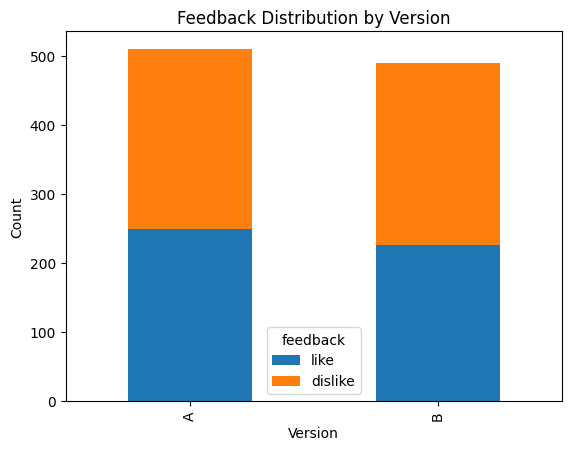

In [ ]:
summary[['like', 'dislike']].plot(kind='bar', stacked=True)
plt.title('Feedback Distribution by Version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.show()